In [22]:
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
import time
import math

In [23]:
class LSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, num_classes: int):
        """
        Think about which (hyper-)parameters your model needs; 
        i.e., parameters that determine the
        exact shape (as opposed to the architecture) of the model.
        There's an embedding layer, which needs to know how many elements it needs to embed,
        and into vectors of what size.
        There's a recurrent layer, which needs to know the size of its input (coming from
        the embedding layer).
        PyTorch also makes it easy to create a stack of such layers in one command;
        the size of the stack can be given here. Finally, the output of the recurrent layer(s) 
        needs to be projected again into a vector of a specified size.
        """
        super(LSTM,self).__init__()
        
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.output_layer = nn.Linear(hidden_size, num_classes)
        # self.relu = nn.ReLU()

        # self.init_hidden()
        
    def forward(self, x, hidden, cell):
        output = self.embedding(x)
        output, (hidden, cell) = self.lstm(output.unsqueeze(1), (hidden, cell))
        output = self.output_layer(output.reshape(output.shape[0], -1))
        return output, (hidden, cell)


    def init_hidden(self, batch_size=1):
        if batch_size == 1:
            hidden = torch.zeros(self.num_layers, self.hidden_size)
            cell = torch.zeros(self.num_layers, self.hidden_size)
        else:
            hidden = torch.zeros(self.num_layers, batch_size, self.hidden_size)
            cell = torch.zeros(self.num_layers,  batch_size, self.hidden_size)    
        return hidden, cell

In [24]:
import unidecode
import string
import random

CHUNK_LEN = 200
TRAIN_PATH = '../data/dickens_train.txt'

def load_dataset(path):
    all_characters = string.printable
    n_characters = len(all_characters)

    file = unidecode.unidecode(open(path, 'r').read())
    return file

def random_chunk():
    file = load_dataset(TRAIN_PATH)
    start_index = random.randint(0, len(file) - CHUNK_LEN - 1)
    end_index = start_index + CHUNK_LEN + 1
    return file[start_index:end_index]

def char_tensor(strings):
    all_characters = string.printable
    tensor = torch.zeros(len(strings)).long()
    for index,char in enumerate(strings):
        tensor[index] = all_characters.index(char)
    return Variable(tensor)

def random_training_set():
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

def time_since(since):
    """
    A helper to print the amount of time passed.
    """
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [25]:
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8):
    hidden, cell = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str
    all_characters = string.printable

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, (hidden, cell) = decoder(prime_input[p], (hidden, cell)) 
    inp = prime_input[-1]

    for p in range(predict_len):
        output, (hidden, cell) = decoder(inp, (hidden, cell))

        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted


def train(decoder, decoder_optimizer, inp, target):
    hidden, cell = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0
    criterion = nn.CrossEntropyLoss()

    for c in range(CHUNK_LEN):
        output, (hidden, cell) = decoder(inp[c], hidden, cell)
        loss += criterion(output, target[c].view(1))

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / CHUNK_LEN

In [26]:
all_characters = string.printable
n_characters = len(all_characters)

n_epochs = 3000
print_every = 100
plot_every = 10
hidden_size = 128
n_layers = 2

lr = 0.005
decoder = LSTM(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs+1):
    loss = train(decoder, decoder_optimizer, *random_training_set())
    loss_avg += loss

    if epoch % print_every == 0:
        print('[{} ({} {}%) {:.4f}]'.format(time_since(start), epoch, epoch/n_epochs * 100, loss))
        print(generate(decoder, 'A', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


RuntimeError: input.size(-1) must be equal to input_size. Expected 100, got 1

In [27]:
all_characters = string.printable
n_characters = len(all_characters)

n_epochs = 3000
print_every = 100
plot_every = 10
hidden_size = 128
n_layers = 2

lr = 0.005
decoder = LSTM(n_characters, hidden_size, n_layers, n_characters)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)

In [28]:
print(decoder)

LSTM(
  (embedding): Embedding(100, 128)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True)
  (output_layer): Linear(in_features=128, out_features=100, bias=True)
)


In [168]:
print(decoder_optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0
)


In [169]:
hidden, cell = decoder.init_hidden()
decoder.zero_grad()
loss = 0
criterion = nn.CrossEntropyLoss()

In [170]:
hidden.size()

torch.Size([2, 128])

In [171]:
cell.size()

torch.Size([2, 128])

In [172]:
inp, target = random_training_set()

In [173]:
decoder(inp[0],hidden,cell)

RuntimeError: input.size(-1) must be equal to input_size. Expected 100, got 1

In [189]:
t = torch.zeros(100).long()
t[inp[0]] = 1.
t

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

In [190]:
emb = decoder.embedding(t)

In [191]:
emb.size()

torch.Size([100, 128])

In [192]:
lstm = nn.LSTM(n_characters, hidden_size, 2, batch_first = False)

In [195]:
lstm(emb,(hidden,cell))

RuntimeError: input.size(-1) must be equal to input_size. Expected 100, got 128

In [1]:
hyperparam_list = [
            {"n_epochs" : 3000, "hidden_size" : 128, "n_layers" : 2, "lr" : 0.005, "opt" : "Adam"},
            {"n_epochs" : 3500, "hidden_size" : 128, "n_layers" : 2, "lr" : 0.005, "opt" : "Adam"},
            {"n_epochs" : 4000, "hidden_size" : 128, "n_layers" : 2, "lr" : 0.005, "opt" : "Adam"},
            {"n_epochs" : 4500, "hidden_size" : 128, "n_layers" : 2, "lr" : 0.005, "opt" : "Adam"}, # tune n_epochs
            {"n_epochs" : 3000, "hidden_size" : 32, "n_layers" : 2, "lr" : 0.005, "opt" : "Adam"},
            {"n_epochs" : 3000, "hidden_size" : 64, "n_layers" : 2, "lr" : 0.005, "opt" : "Adam"},
            
            {"n_epochs" : 3000, "hidden_size" : 256, "n_layers" : 2, "lr" : 0.005, "opt" : "Adam"}, # tune hidden_size
            {"n_epochs" : 3000, "hidden_size" : 128, "n_layers" : 1, "lr" : 0.005, "opt" : "Adam"},
            
            {"n_epochs" : 3000, "hidden_size" : 128, "n_layers" : 3, "lr" : 0.005, "opt" : "Adam"},
            {"n_epochs" : 3000, "hidden_size" : 128, "n_layers" : 4, "lr" : 0.005, "opt" : "Adam"}, # tune n_layers
            
            {"n_epochs" : 3000, "hidden_size" : 128, "n_layers" : 2, "lr" : 0.01, "opt" : "Adam"},
            {"n_epochs" : 3000, "hidden_size" : 128, "n_layers" : 2, "lr" : 0.015, "opt" : "Adam"},
            {"n_epochs" : 3000, "hidden_size" : 128, "n_layers" : 2, "lr" : 0.02, "opt" : "Adam"}, # tune lr
            
            {"n_epochs" : 3000, "hidden_size" : 128, "n_layers" : 2, "lr" : 0.005, "opt" : "AdamW"},
            {"n_epochs" : 3000, "hidden_size" : 128, "n_layers" : 2, "lr" : 0.005, "opt" : "RMSprop"} # tune opt
            ]

In [30]:
for hyperparams in hyperparam_list:
    tuner(**hyperparams)

3000 100 10 128 2 0.005 A 100 0.8 Adam
3500 100 10 128 2 0.005 A 100 0.8 Adam
4000 100 10 128 2 0.005 A 100 0.8 Adam
4500 100 10 128 2 0.005 A 100 0.8 Adam
3000 100 10 32 2 0.005 A 100 0.8 Adam
3000 100 10 64 2 0.005 A 100 0.8 Adam
3000 100 10 256 2 0.005 A 100 0.8 Adam
3000 100 10 128 1 0.005 A 100 0.8 Adam
3000 100 10 128 3 0.005 A 100 0.8 Adam
3000 100 10 128 4 0.005 A 100 0.8 Adam
3000 100 10 128 2 0.01 A 100 0.8 Adam
3000 100 10 128 2 0.015 A 100 0.8 Adam
3000 100 10 128 2 0.02 A 100 0.8 Adam
3000 100 10 128 2 0.005 A 100 0.8 AdamW
3000 100 10 128 2 0.005 A 100 0.8 RMSprop


In [7]:
def test_inputs(n_epochs, hidden_size, n_layers,lr,opt):
    print(n_epochs, hidden_size, n_layers,lr,opt)

In [29]:
def tuner(n_epochs : int = 3000,
          print_every : int = 100,
          plot_every  : int = 10,
          hidden_size : int = 128,
          n_layers : int = 2,
          lr :float = 0.005,
          start_string : str = 'A',
          prediction_length : int = 100,
          temperature : float = 0.8,
          opt : str = "Adam"):
    print(n_epochs,print_every,plot_every,hidden_size,n_layers,lr,start_string,prediction_length,temperature,opt)

In [39]:
import random
import matplotlib.pyplot as plt

In [37]:
all_colours = ["red","blue","green","yellow","purple","black","violet","grey","cyan","magenta"]
colours = random.sample(all_colours,5)

In [42]:
lr_list = [0.1,0.05,0.01,0.005,0.001]

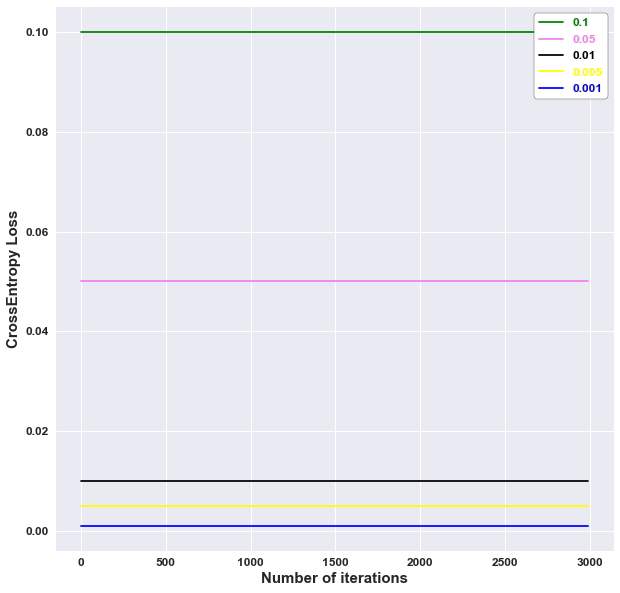

In [59]:
plt.style.use('seaborn')
plt.figure(figsize=(10,10))
plt.xticks(fontweight='bold', size=12)
plt.yticks(fontweight='bold', size=12)
plt.tick_params(axis='both', direction='in')
all_colours = ["red","blue","green","yellow","purple","black","violet","grey","cyan","magenta"]
colours = random.sample(all_colours,len(lr_list))
x = np.arange(0,3000,10)
for index,lr in enumerate(lr_list):
    plt.plot(x,[lr]*300,colours[index],label = f"{lr}")
    
plt.xlabel("Number of iterations",fontsize=15,fontweight='bold')
plt.ylabel("CrossEntropy Loss",fontsize=15,fontweight='bold')
plt.legend(prop = {"size":12,"weight":"bold"},loc='best',labelcolor='linecolor',
           frameon = True, fancybox = True,framealpha=1,
           facecolor = "white", edgecolor="black")

In [ ]:
values =  [2.4994462558563946,2.4225304126160276,2.945138813506362,2.6649904551517634,2.3927558140149703,2.503693651509312,2.605775321127309, 2.7594953814404346, 2.54451165817949, 2.664610644079394, 2.6922874844239466, 2.5109406691908243, 2.366963940213506]

In [60]:
import string

all_characters

'0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ \t\n\r\x0b\x0c'

In [61]:
n_characters

100

In [75]:
import csv

# Sample data with headers
data = [
    {'Name': 'John', 'Age': 25, 'City': 'New York'},
    {'Name': 'Alice', 'Age': 30, 'City': 'San Francisco'},
    {'Name': 'Bob', 'Age': 22, 'City': 'Los Angeles'}
]

new = {"Work" : ["A","B","C"]}

In [74]:
# Specify the file name
file_name = 'test.txt'

# Write data with headers to the file
with open(file_name, 'w', newline='') as file:
    # Extract headers from the first dictionary
    headers = list(data[0].keys())

    # Create a CSV writer
    writer = csv.DictWriter(file, fieldnames=headers,delimiter="\t")

    # Write headers to the file
    writer.writeheader()
    
    writer.writerows(data)
    

print(f"Data with headers written to '{file_name}'")

Data with headers written to 'test.txt'


In [77]:
hyperparam_list = [
            {"n_epochs" : 2000, "hidden_size" : 128, "n_layers" : 2, "lr" : 0.005, "opt" : "Adam"},
            {"n_epochs" : 4000, "hidden_size" : 128, "n_layers" : 2, "lr" : 0.005, "opt" : "Adam"}, # tune n_epochs
            {"n_epochs" : 2000, "hidden_size" : 64, "n_layers" : 2, "lr" : 0.005, "opt" : "Adam"},
            {"n_epochs" : 2000, "hidden_size" : 256, "n_layers" : 2, "lr" : 0.005, "opt" : "Adam"}, # tune hidden_size
            {"n_epochs" : 2000, "hidden_size" : 128, "n_layers" : 1, "lr" : 0.005, "opt" : "Adam"},
            {"n_epochs" : 2000, "hidden_size" : 128, "n_layers" : 3, "lr" : 0.005, "opt" : "Adam"}, # tune n_layers
            {"n_epochs" : 2000, "hidden_size" : 128, "n_layers" : 2, "lr" : 0.1, "opt" : "Adam"},
            {"n_epochs" : 2000, "hidden_size" : 128, "n_layers" : 2, "lr" : 0.01, "opt" : "Adam"},
            {"n_epochs" : 2000, "hidden_size" : 128, "n_layers" : 2, "lr" : 0.001, "opt" : "Adam"}, # tune lr
            {"n_epochs" : 2000, "hidden_size" : 128, "n_layers" : 2, "lr" : 0.005, "opt" : "AdamW"},
            {"n_epochs" : 2000, "hidden_size" : 128, "n_layers" : 2, "lr" : 0.005, "opt" : "RMSprop"}, # tune opt
            {"n_epochs" : 2000, "hidden_size" : 256, "n_layers" : 2, "lr" : 0.005, "opt" : "RMSprop"}
            ]

In [99]:
values =  [2.4994462558563946,2.4225304126160276,2.945138813506362,2.6649904551517634,2.3927558140149703,2.503693651509312,2.605775321127309, 2.7594953814404346, 2.54451165817949, 2.664610644079394, 2.6922874844239466, 2.5109406691908243]

In [100]:
len(hyperparam_list)

12

In [101]:
len(values)

12

In [102]:
file_name = 'test.txt'
with open(file_name, 'w', newline='') as file:
    headers = list(hyperparam_list[0].keys())
    headers.append("BPC")

    writer = csv.DictWriter(file, fieldnames = headers, delimiter="\t")

    writer.writeheader()
    for hyperparams, value in zip(hyperparam_list,values):
        # print(f"{keys} Configuration {hyperparams}\n BPC = {values}")
        writer.writerow(hyperparams | {"BPC" : value})

In [95]:
headers

['n_epochs', 'hidden_size', 'n_layers', 'lr', 'opt', 'BPC']

In [92]:
headers.append("BPC")

In [93]:
headers

['n_epochs', 'hidden_size', 'n_layers', 'lr', 'opt', 'BPC']